## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
print(df.shape)

(294478, 5)


c. The number of unique users in the dataset.

In [4]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [5]:
df.drop_duplicates('user_id').converted.mean()

0.1195695564793657

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
control_df = df.query('group == "control" & landing_page == "new_page"').count()
control_df

user_id         1928
timestamp       1928
group           1928
landing_page    1928
converted       1928
dtype: int64

In [7]:
treatment_df = df.query('group == "treatment" & landing_page == "old_page"').count()
treatment_df

user_id         1965
timestamp       1965
group           1965
landing_page    1965
converted       1965
dtype: int64

In [8]:
control_treat_sum = control_df + treatment_df
control_treat_sum

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [9]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
df2 = df.query("(group == 'control' & landing_page == 'old_page') | (group == 'treatment' & landing_page == 'new_page')")

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
ids = df2["user_id"]
df_dupe = df2[ids.isin(ids[ids.duplicated()])]
df_dupe.user_id

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2.drop_duplicates('user_id', keep="first")

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
(df2.query('converted == 1').count() / df2.count())[0]

0.11959667567149027

In [17]:
# Confirming the mean will also work because `converted` is binary
df2.converted.mean()

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
control_prob = df2.query("group == 'control'")['converted'].mean()
control_prob

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
treatment_prob = df2.query("group == 'treatment'")['converted'].mean()
treatment_prob

0.11880724790277405

d. What is the probability that an individual received the new page?

In [20]:
# Count number of times new_page was shown and divide it by size of original dataset
new_page_prob = df2.query('landing_page == "new_page"').count() / df2.count()
new_page_prob

user_id         0.500064
timestamp       0.500064
group           0.500064
landing_page    0.500064
converted       0.500064
dtype: float64

In [21]:
# Checking alternative way to arrive at answer above using the mean
(df2["landing_page"]=="new_page").mean()

0.5000636646764286

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

> **Since we are dealing with only two outcomes, converted or not converted for the new page and old page, the probability should always be 0.5. Based on the analysis above, it appears as though regardless of what page an individual received, the probability remained within a similar margin for those converting in the control and treatment groups. In other words, it seems that the probability of users converting is roughly the same for both groups. This would leave me to conclude that there is not sufficient evidence that the new page would lead to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

#### Null hypothesis: 
> The new page is equal to or worse than the old page: `p_new - p_old <= 0`

#### Alternative hypothesis: 
> The new page is better than the old page: `p_new - p_old > 0`

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [22]:
p_new = df2.converted.mean()
p_new

0.11959667567149027

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [23]:
p_old = df2.converted.mean()
p_old

0.11959667567149027

c. What is $n_{new}$, the number of individuals in the treatment group?

In [24]:
n_new = df2.query('group == "treatment"').count()[0]
n_new

145311

d. What is $n_{old}$, the number of individuals in the control group?

In [25]:
n_old = df2.query('group == "control"').count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted_v1 = p_new - p_old
new_page_converted_v1

0.0

In [27]:
new_page_converted = np.random.binomial(1,p_new, n_new)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted = np.random.binomial(1,p_old, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
new_old_p_diff = new_page_converted.mean() - old_page_converted.mean()
new_old_p_diff

-0.0004091012189276211

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [30]:
p_diffs = []
new_p_convert = np.random.binomial(n_new, p_new, 10000) / n_new
old_p_convert = np.random.binomial(n_old, p_old, 10000) / n_old
p_diffs = new_p_convert - old_p_convert

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [31]:
p_diffs = np.array(p_diffs)

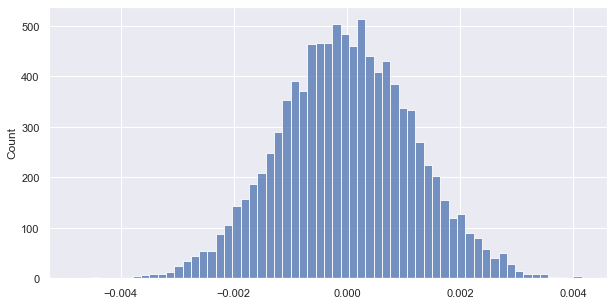

In [32]:
plt.figure(figsize=[10,5])
sns.histplot(p_diffs);

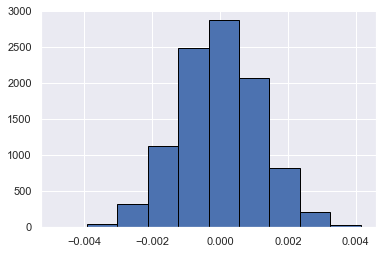

In [33]:
# Viewing alternative histogram of the same data
plt.hist(p_diffs, ec='black');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
treatment_mean = df2.query('group == "treatment"').converted.mean()
control_mean = df2.query('group == "control"').converted.mean()
actual_diff = treatment_mean - control_mean
(p_diffs > actual_diff).mean()

0.9054

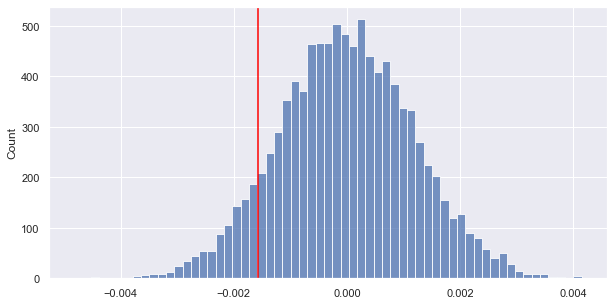

In [35]:
plt.figure(figsize=[10,5])
sns.histplot(p_diffs);
plt.axvline(x = actual_diff, color = 'red');

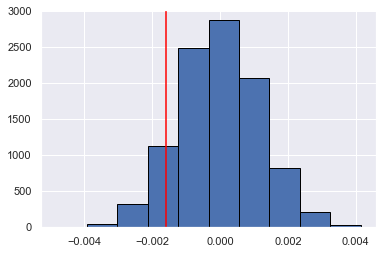

In [36]:
# Viewing alternative histogram of the same data
plt.hist(p_diffs, ec='black');
plt.axvline(x = actual_diff, color = 'red');

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> **The p-value is the probability of observing your statistic (or one more extreme in favor of the alternative) if the null hypothesis is true. I got a value of 0.9 as the p-value in part "j". This suggests that in the simulated results, 90% of them are equal to or greater than the original values in the dataset. Therefore, I fail to reject the hypothesis because the p-value is greater than 0.05. There does not appear to be a significant difference between the new and old page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [37]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group == "treatment"').converted.sum()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [38]:
z_stat, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_stat, p_value)

1.3116075339133115 0.905173705140591


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

> **Using `stats.proprtions.ztest`, the p-value is in agreement with my findings in "j" and "k". This means that 0.9 (e.g. 90%) of the simulated distribution is equal to or greater than the difference in the original dataset. I still fail to reject the hypothesis because there is not a significant difference between the simulation and actual distribution.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

> **The type of regression I will use is logistic regression. This will allow me to predict a categorical variable (e.g. new page or old page) based on a binary response (conversion or no conversion via 0 and 1).**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [39]:
df2['intercept'] = 1
df2[['new_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

In [40]:
df2.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [41]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [42]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Wed, 20 Jan 2021   Pseudo R-squ.:               8.085e-06
Time:                        11:20:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

> **The p-value associated with `ab_page` is 0.19. This differs from the value found in part II because this iteration is a two-tailed test.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> **Adding other factors has the ability to increase the accuracy of the regression model. However, there are disadvantages as well. Issues that can arise by adding additional terms into the regression model are variance inflation factors and how multicolinearity impacts the model coefficients and standard errors.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [43]:
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [44]:
df2 = df2.join(countries.set_index('user_id'), on='user_id')
df2.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US


In [45]:
df2[['US', 'UK']] = pd.get_dummies(df2['country'])[['US', 'UK']]
df2.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country,US,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US,1,0


In [52]:
# Instantiate a model to determine if there's a significant difference or effect of the country on conversion
logit_mod_2 = sm.Logit(df2['converted'], df2[['intercept', 'ab_page','US','UK']])
results_2 = logit_mod_2.fit()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


In [53]:
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            3
Date:                Wed, 20 Jan 2021   Pseudo R-squ.:               2.324e-05
Time:                        11:24:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1758
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0150      0.011     -1.308      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

> **Based on the statistical output above, it does not appear that the country had an impact on page conversion.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [ ]:
df2['US_ab_page'] = df2['US'] * df2['ab_page']
df2['UK_ab_page'] = df2['UK'] * df2['ab_page']
df2.head(3)

In [ ]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'US', 'UK', 'ab_page', 'US_ab_page', 'UK_ab_page']])
sum_result = logit_mod.fit()
sum_result.summary()

<a id='conclusions'></a>
## Conclusion

> **Due to the p-value being consistently larger than 0.05, I fail to reject the null hypothesis. Therefore, the company should implement the new page. However, just because the sample did not provide sufficient evidence to conclude the null hypothesis is valid, that lack of evidence also doesn't prove that it does not exist. I would encourage the company to do additional tests or if they move forward with implementation, they should closely monitor their conversions and run additional tests with the new data.**